In [2]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import collections

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import encrypt
import re
import seaborn as sns
sns.set(color_codes=True)

In [4]:
def getFrequencyOfText(inputText):
    d = collections.Counter(inputText)
    d.pop(' ', -1) # remove space
    b = sorted(list(d.values()), reverse=True)
    n = sum(b)+0.0
    b.extend([0] * (26-len(b)))
    b = np.array(b, dtype=float)
    b = 100*(b/n)
    return b

In [5]:
simple_sub = open("./data_gen/data/train/simple_sub_long.txt").read().splitlines()
vigenere = open("./data_gen/data/train/vig_long.txt").read().splitlines()

In [6]:
N = 2000
M = 26 # Number of features
simple_sub = simple_sub[:N]
vigenere = vigenere [:N]

In [7]:
plain_text = "IN CRYPTOGRAPHY A SUBSTITUTION CIPHER IS A METHOD OF ENCRYPTING BY WHICH UNITS OFPLAINTEXT ARE REPLACED WITH CIPHERTEXT ACCORDING TO A FIXED SYSTEM THE UNITSMAY BE SINGLE LETTERS THE MOST COMMONPAIRS OF LETTERS TRIPLETS OF LETTERS MIXTURES OF THE ABOVE AND SO FORTHTHE RECEIVER DECIPHERS THE TEXT BY PERFORMING THE INVERSE SUBSTITUTION"
key = "VIGENERE"
vigenere_text = encrypt.vigenere(key, plain_text)
key = "THECOWSGMINFLDABJKPQRUVXYZ"
simple_subs_text = encrypt.simple_subs(key, plain_text)

In [8]:
p = getFrequencyOfText(plain_text)
v = getFrequencyOfText(vigenere_text)
s = getFrequencyOfText(simple_subs_text)

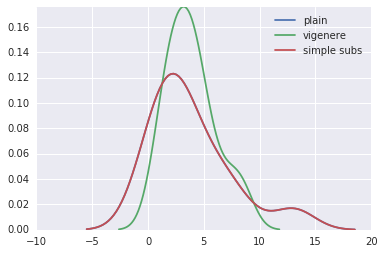

In [9]:
sns.kdeplot(p, label = "plain")
sns.kdeplot(v, label="vigenere")
sns.kdeplot(s, label="simple subs")

* Plain text distribution is completely hidden by vigenere which is quite obvious due to the choice of the features used

In [10]:
def get_training_data():
    """ Returns 
        x -> 2000, 27
        y -> 2000, 1
        0 for vigenere and 1 for simple subs
    """ 
    xs = np.ones((int(N/2), M+1))
    xv = np.ones((int(N/2), M+1))
    for i in range(int(N/2)):
        s = getFrequencyOfText(simple_sub[i])
        v = getFrequencyOfText(vigenere[i])
        
        xs[i, 1:] = s
        xv[i, 1:] = v
    
    x = np.vstack((xv, xs))
    
    target = [0]*1000 + [1]*1000
    num_labels = len(np.unique(target))
    y = np.eye(num_labels)[target]
    
    return x, y        

In [11]:
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

# NOTE: In order to make the code simple, we rewrite x * W_1 + b_1 = x' * W_1'
# where x' = [x | 1] and W_1' is the matrix W_1 appended with a new row with elements b_1's.
# Similarly, for h * W_2 + b_2
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

In [12]:
all_X, all_Y = get_training_data()

In [13]:
train_X, test_X, train_y, test_y = train_test_split(all_X, all_Y, test_size=0.33, random_state=RANDOM_SEED)

# Layer's sizes
x_size = train_X.shape[1]   # Number of input nodes: 26 features and 1 bias
h_size = 256                # Number of hidden nodes
y_size = train_y.shape[1]   # Number of outcomes 2

# Symbols
X = tf.placeholder("float", shape=[None, x_size])
y = tf.placeholder("float", shape=[None, y_size])

# Weight initializations
w_1 = init_weights((x_size, h_size))
w_2 = init_weights((h_size, y_size))

# Forward propagation
yhat    = forwardprop(X, w_1, w_2)
predict = tf.argmax(yhat, axis=1)

# Backward propagation
cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
updates = tf.train.AdamOptimizer().minimize(cost)

# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(10):
    # Train with each example
    for i in range(len(train_X)):
        sess.run(updates, feed_dict={X: train_X[i: i + 1], y: train_y[i: i + 1]})
    train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                             sess.run(predict, feed_dict={X: train_X, y: train_y}))
    test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                             sess.run(predict, feed_dict={X: test_X, y: test_y}))
    print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
          % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch = 1, train accuracy = 99.55%, test accuracy = 99.70%
Epoch = 2, train accuracy = 99.63%, test accuracy = 99.70%
Epoch = 3, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 4, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 5, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 6, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 7, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 8, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 9, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 10, train accuracy = 99.48%, test accuracy = 99.85%


### Testing on the test set given 

In [14]:
vig = open("./data_gen/data/test/vig.txt").read().splitlines()
ss = open("./data_gen/data/test/simple_sub.txt").read().splitlines()

In [15]:
res = []
for line in vig:
    x = np.ones((1, 27))
    x[:, 1:] = getFrequencyOfText(line).reshape(1, -1)
    out = sess.run(predict, feed_dict={ X:x })
    res += [out]

In [16]:
res

[array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0])]

In [17]:
res = []
for line in ss:
    x = np.ones((1, 27))
    x[:, 1:] = getFrequencyOfText(line).reshape(1, -1)
    out = sess.run(predict, feed_dict={ X:x })
    res += [out]

In [18]:
res

[array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1])]

### Let's test it out even more

In [19]:
def test_it(text):
    x = np.ones((1, 27))
    x[:, 1:] = getFrequencyOfText(text).reshape(1, -1)
    out = sess.run(predict, feed_dict={ X:x })
    return out

In [20]:
v = "The Vigenere cipher (French pronunciation: ​[viʒnɛːʁ]) \
    is a method of encrypting alphabetic text by using a series\
    of interwoven Caesar ciphers based on the letters of a keyword. It \
    is a form of polyalphabetic substitution. \
    Though the cipher is easy to understand and implement, for three \
    centuries it resisted all attempts to break it; this earned it the \
    description le chiffre indéchiffrable (French for 'the indecipherable cipher'). "

In [21]:
clean_text = ''.join(re.findall('[A-Za-z ]', v)).upper().strip()

In [22]:
clean_text

'THE VIGENERE CIPHER FRENCH PRONUNCIATION VIN     IS A METHOD OF ENCRYPTING ALPHABETIC TEXT BY USING A SERIES    OF INTERWOVEN CAESAR CIPHERS BASED ON THE LETTERS OF A KEYWORD IT     IS A FORM OF POLYALPHABETIC SUBSTITUTION     THOUGH THE CIPHER IS EASY TO UNDERSTAND AND IMPLEMENT FOR THREE     CENTURIES IT RESISTED ALL ATTEMPTS TO BREAK IT THIS EARNED IT THE     DESCRIPTION LE CHIFFRE INDCHIFFRABLE FRENCH FOR THE INDECIPHERABLE CIPHER'

In [23]:
key = "VIGENERE"
cipher = encrypt.vigenere(key, clean_text)

In [24]:
cipher
test_it(cipher)

array([0])

In [25]:
s = "In cryptography, a substitution cipher is a method of encrypting by which units of\
plaintext are replaced with ciphertext, according to a fixed system; the units\
may be single letters (the most common),\
pairs of letters, triplets of letters, mixtures of the above, and so forth.\
The receiver deciphers the text by performing the inverse substitution."

In [26]:
clean_text = ''.join(re.findall('[A-Za-z ]', s)).upper().strip()

In [27]:
clean_text

'IN CRYPTOGRAPHY A SUBSTITUTION CIPHER IS A METHOD OF ENCRYPTING BY WHICH UNITS OFPLAINTEXT ARE REPLACED WITH CIPHERTEXT ACCORDING TO A FIXED SYSTEM THE UNITSMAY BE SINGLE LETTERS THE MOST COMMONPAIRS OF LETTERS TRIPLETS OF LETTERS MIXTURES OF THE ABOVE AND SO FORTHTHE RECEIVER DECIPHERS THE TEXT BY PERFORMING THE INVERSE SUBSTITUTION'

In [28]:
key = "THECOWSGMINFLDABJKPQRUVXYZ"

In [29]:
cipher = encrypt.simple_subs(key, clean_text)
test_it(cipher)

array([1])

In [30]:
sess.close()